# Latent Diffusion Models

[Paper here](https://arxiv.org/pdf/2112.10752)


In [1]:
# %cd "Deep-Learning-From-Scratch/Generative Models/DDPM"

In [2]:
from rich import print
from tqdm.notebook import tqdm

%load_ext rich


In [96]:
import math
from functools import partial

import einops
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import torch
from einops.layers.torch import Rearrange, Reduce
from transformers import CLIPTokenizer, CLIPTextModel
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
%load_ext autoreload
%autoreload 2

import models
import ddpm

In [108]:
from dataclasses import dataclass


@dataclass
class Config:
    BATCH_SIZE: int = 8
    LEARNING_RATE: float = 2e-5
    N_EPOCHS: int = 150
    N_TIMESTEPS: int = 1000
    IMAGE_SIZE: int = 128

    IN_CHANNELS: int = 3
    LATENT_SIZE: int = 4
    AE_BASE_CHANNELS: int = 128
    UNET_BASE_CHANNELS: int = 320
    D_CONTEXT: int = 512
    N_GROUPS: int = 32
    N_ATTN_HEADS: int = 1

## Load the data

In [109]:
cfg = Config()

In [7]:
transform = transforms.Compose(
    [
        transforms.Resize(cfg.IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x - 0.5) * 2),
    ]
)


def reverse_transform(x):
    return transforms.ToPILImage()((x / 2 + 0.5).clamp(0, 1))

In [97]:
target_classes = [
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]


In [8]:
train_dataset = CIFAR10(root="./data", train=True, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=cfg.BATCH_SIZE, shuffle=True)

Files already downloaded and verified


In [9]:
sample_images, sample_targets = next(iter(train_loader))

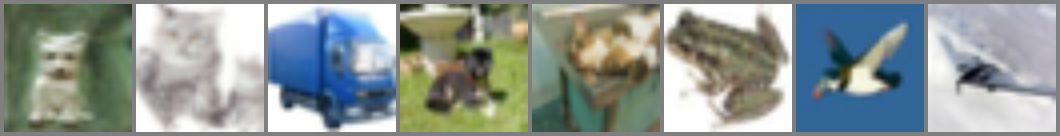

In [10]:
reverse_transform(make_grid(sample_images, nrow=8, padding=4))

## Build the architecture

In [11]:
_ = models.ConvBlock(3, 16, groups=1, debug=True)(torch.randn(2, 3, 32, 32))

[ConvBlock] Input: torch.Size([2, 3, 32, 32])

[ConvBlock] Norm: torch.Size([2, 3, 32, 32])

[ConvBlock] SiLU: torch.Size([2, 3, 32, 32])

[ConvBlock] Output: torch.Size([2, 16, 32, 32])

In [12]:
_ = models.ResNetBlock(128, 256, debug=True)(torch.randn(2, 128, 32, 32))


[ResNetBlock] Input: torch.Size([2, 128, 32, 32])

[ResNetBlock] Block1: torch.Size([2, 256, 32, 32])

[ResNetBlock] Block2: torch.Size([2, 256, 32, 32])

In [13]:
_ = models.SelfAttentionBlock(8, 256, debug=True)(torch.randn(2, 1024, 256))

[SelfAttentionBlock] Input: torch.Size([2, 1024, 256])

[SelfAttentionBlock] Q: torch.Size([2, 8, 1024, 32])

[SelfAttentionBlock] K: torch.Size([2, 8, 1024, 32])

[SelfAttentionBlock] V: torch.Size([2, 8, 1024, 32])

[SelfAttentionBlock] Attention: torch.Size([2, 8, 1024, 1024])

[SelfAttentionBlock] Out: torch.Size([2, 1024, 256])

[SelfAttentionBlock] Projection: torch.Size([2, 1024, 256])

In [14]:
_ = models.CrossAttentionBlock(n_heads=8, d_embd=256, d_context=768, debug=True)(
    torch.randn(2, 1024, 256), torch.randn(2, 77, 768)
)

[CrossAttentionBlock] Input: torch.Size([2, 1024, 256])

[CrossAttentionBlock] Context: torch.Size([2, 77, 768])

[CrossAttentionBlock] Q: torch.Size([2, 8, 1024, 32])

[CrossAttentionBlock] K: torch.Size([2, 8, 77, 32])

[CrossAttentionBlock] V: torch.Size([2, 8, 77, 32])

[CrossAttentionBlock] Attention: torch.Size([2, 8, 1024, 77])

[CrossAttentionBlock] Out: torch.Size([2, 1024, 256])

[CrossAttentionBlock] Output: torch.Size([2, 1024, 256])

In [15]:
_ = models.ResNetBlock(128, 128, n_groups=32, debug=True)(torch.randn(2, 128, 32, 32))

[ResNetBlock] Input: torch.Size([2, 128, 32, 32])

[ResNetBlock] Block1: torch.Size([2, 128, 32, 32])

[ResNetBlock] Block2: torch.Size([2, 128, 32, 32])

In [16]:
_ = models.VAEAttentionBlock(8, 256, debug=True)(torch.randn(2, 256, 32, 32))

[VAEAttentionBlock] Input: torch.Size([2, 256, 32, 32])

[VAEAttentionBlock] Output: torch.Size([2, 256, 32, 32])

In [17]:
encoded = models.VAEEncoder(
    in_channels=cfg.IN_CHANNELS,
    latent_size=cfg.LATENT_SIZE,
    base_channels=cfg.AE_BASE_CHANNELS,
    n_groups=cfg.N_GROUPS,
    n_attn_heads=cfg.N_ATTN_HEADS,
    debug=True,
)(sample_images[:2], torch.randn(2, cfg.LATENT_SIZE, 1, 1))

[VAEEncoder] Input: torch.Size([2, 3, 128, 128])

[VAEEncoder] Init Conv: torch.Size([2, 128, 128, 128])

[VAEEncoder] Block 0: torch.Size([2, 128, 64, 64])

[VAEEncoder] Block 1: torch.Size([2, 256, 32, 32])

[VAEEncoder] Block 2: torch.Size([2, 512, 16, 16])

[VAEEncoder] Block 3: torch.Size([2, 512, 16, 16])

[VAEEncoder] Block 4: torch.Size([2, 8, 16, 16])

[VAEEncoder] Z: torch.Size([2, 4, 16, 16])

[VAEEncoder] Output: torch.Size([2, 4, 16, 16])

In [18]:
decoded = models.VAEDecoder(
    latent_size=cfg.LATENT_SIZE,
    base_channels=cfg.AE_BASE_CHANNELS,
    in_channels=cfg.IN_CHANNELS,
    n_groups=cfg.N_GROUPS,
    n_attn_heads=cfg.N_ATTN_HEADS,
    debug=True,
)(encoded)

[VAEDecoder] Input: torch.Size([2, 4, 16, 16])

[VAEDecoder] Init Conv: torch.Size([2, 4, 16, 16])

[VAEDecoder] Block 0: torch.Size([2, 512, 16, 16])

[VAEDecoder] Block 1: torch.Size([2, 512, 16, 16])

[VAEDecoder] Block 2: torch.Size([2, 512, 32, 32])

[VAEDecoder] Block 3: torch.Size([2, 256, 64, 64])

[VAEDecoder] Block 4: torch.Size([2, 128, 128, 128])

[VAEDecoder] Block 5: torch.Size([2, 3, 128, 128])

[VAEDecoder] Output: torch.Size([2, 3, 128, 128])

Original image:

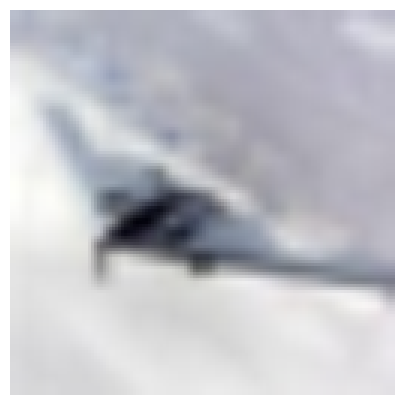

Encoded images:

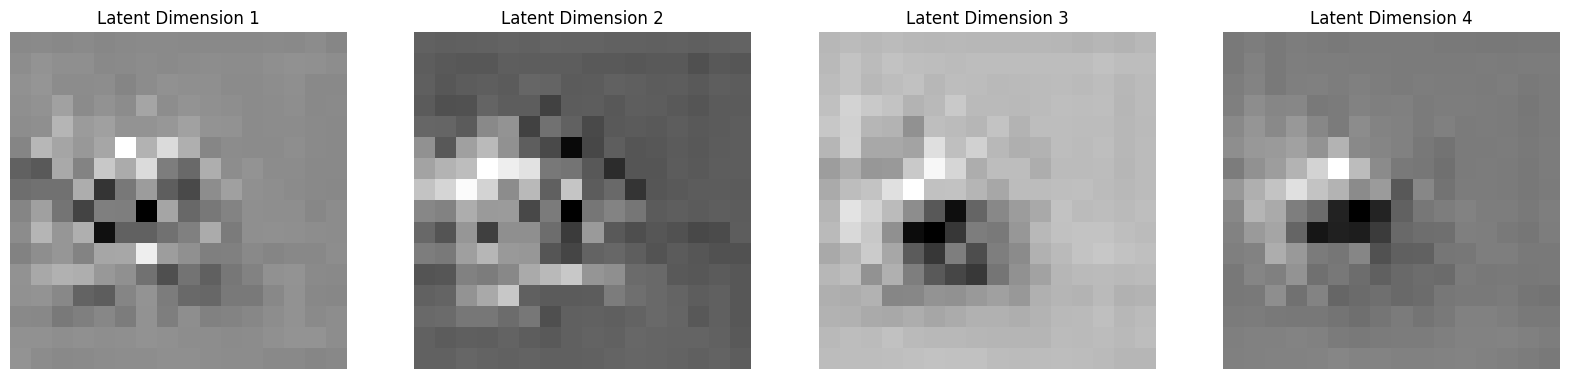

Decoded image:

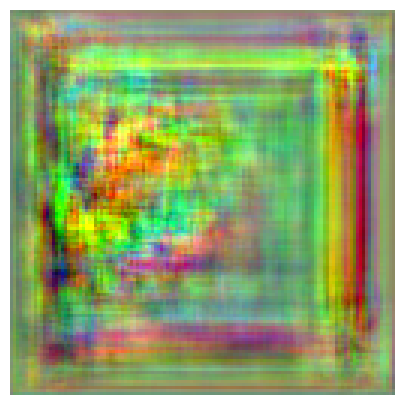

In [19]:
class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(AutoEncoder, self).__init__()

        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x, noise):
        x = self.encoder(x, noise)
        x = self.decoder(x)
        return x


ae_model = AutoEncoder(
    encoder=models.VAEEncoder(
        in_channels=cfg.IN_CHANNELS,
        latent_size=cfg.LATENT_SIZE,
        base_channels=cfg.AE_BASE_CHANNELS,
        n_groups=cfg.N_GROUPS,
        n_attn_heads=cfg.N_ATTN_HEADS,
    ),
    decoder=models.VAEDecoder(
        latent_size=cfg.LATENT_SIZE,
        base_channels=cfg.AE_BASE_CHANNELS,
        in_channels=cfg.IN_CHANNELS,
        n_groups=cfg.N_GROUPS,
        n_attn_heads=cfg.N_ATTN_HEADS,
    ),
)

print("Original image:")
plt.figure(figsize=(5, 5))
plt.imshow(reverse_transform(sample_images[7]))
plt.axis("off")

plt.show()


encoded = ae_model.encoder(
    sample_images[7].unsqueeze(0), torch.randn(1, cfg.LATENT_SIZE, 1, 1)
)
print("Encoded images:")
fig, axs = plt.subplots(1, cfg.LATENT_SIZE, figsize=(20, 5))
for i in range(cfg.LATENT_SIZE):
    axs[i].imshow(encoded[0, i].detach().cpu().numpy(), cmap="gray")
    axs[i].set_title(f"Latent Dimension {i+1}")
    axs[i].axis("off")

plt.show()

decoded = ae_model.decoder(encoded)
print("Decoded image:")
plt.figure(figsize=(5, 5))
plt.imshow(reverse_transform(decoded[0].detach().cpu()))
plt.axis("off")

plt.show()

In [20]:
_ = models.ResNetBlock(128, 256, d_time_embd=1280, debug=True)(
    torch.randn(2, 128, 32, 32), torch.randn(1, 1280)
)

[ResNetBlock] Input: torch.Size([2, 128, 32, 32])

[ResNetBlock] Block1: torch.Size([2, 256, 32, 32])

[ResNetBlock] TimeProjection: torch.Size([1, 256])

[ResNetBlock] Block2: torch.Size([2, 256, 32, 32])

In [21]:
_ = models.UnetAttentionBlock(8, 256, 768, debug=True)(
    torch.randn(2, 256, 32, 32), torch.randn(2, 77, 768)
)


[UnetAttentionBlock] Input: torch.Size([2, 256, 32, 32])

[UnetAttentionBlock] Context: torch.Size([2, 77, 768])

[UnetAttentionBlock] Self-Attention: torch.Size([2, 1024, 256])

[UnetAttentionBlock] Cross-Attention: torch.Size([2, 1024, 256])

[UnetAttentionBlock] Feed-Forward: torch.Size([2, 1024, 256])

[UnetAttentionBlock] Output: torch.Size([2, 256, 32, 32])

In [22]:
unet = models.Unet(
    in_channels=cfg.LATENT_SIZE,
    base_channels=cfg.UNET_BASE_CHANNELS,
    d_context=cfg.D_CONTEXT,
    d_time_embd=cfg.UNET_BASE_CHANNELS * 4,
    n_attn_heads=cfg.N_ATTN_HEADS,
    n_groups=cfg.N_GROUPS,
    debug=False,
)

In [23]:
diffusion = models.Diffusion(
    base_channels=cfg.UNET_BASE_CHANNELS,
    unet=unet,
)

In [48]:
# _ = diffusion(encoded, torch.randn(1, 77, 768), torch.randn(1, 320))

In [110]:
g = torch.Generator(device)
encoder = models.VAEEncoder(
    in_channels=cfg.IN_CHANNELS,
    latent_size=cfg.LATENT_SIZE,
    base_channels=cfg.AE_BASE_CHANNELS,
    n_groups=cfg.N_GROUPS,
    n_attn_heads=cfg.N_ATTN_HEADS,
).to(device)
decoder = models.VAEDecoder(
    latent_size=cfg.LATENT_SIZE,
    base_channels=cfg.AE_BASE_CHANNELS,
    in_channels=cfg.IN_CHANNELS,
    n_groups=cfg.N_GROUPS,
    n_attn_heads=cfg.N_ATTN_HEADS,
).to(device)
unet = models.Unet(
    in_channels=cfg.LATENT_SIZE,
    base_channels=cfg.UNET_BASE_CHANNELS,
    d_context=cfg.D_CONTEXT,
    d_time_embd=cfg.UNET_BASE_CHANNELS * 4,
    n_attn_heads=cfg.N_ATTN_HEADS,
    n_groups=cfg.N_GROUPS,
).to(device)
diffusion = models.Diffusion(
    base_channels=cfg.UNET_BASE_CHANNELS,
    unet=unet,
).to(device)
pipeline = ddpm.DDPMPipeline(g).to(device)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:23                                                                                   │
│                                                                                                  │
│   20 │   d_time_embd=cfg.UNET_BASE_CHANNELS * 4,                                                 │
│   21 │   n_attn_heads=cfg.N_ATTN_HEADS,                                                          │
│   22 │   n_groups=cfg.N_GROUPS,                                                                  │
│ ❱ 23 ).to(device)                                                                                │
│   24 diffusion = models.Diffusion(                                                               │
│   25 │   base_channels=cfg.UNET_BASE_CHANNELS,                                                   │
│   26 │   unet=unet,                                                                              │
│                                                                                                  │
│ e:\Projects\deep-learning-scratch\.venv\Lib\site-packages\torch\nn\modules\module.py:1173 in to  │
│                                                                                                  │
│   1170 │   │   │   │   else:                                                                     │
│   1171 │   │   │   │   │   raise                                                                 │
│   1172 │   │                                                                                     │
│ ❱ 1173 │   │   return self._apply(convert)                                                       │
│   1174 │                                                                                         │
│   1175 │   def register_full_backward_pre_hook(                                                  │
│   1176 │   │   self,                                                                             │
│                                                                                                  │
│ e:\Projects\deep-learning-scratch\.venv\Lib\site-packages\torch\nn\modules\module.py:779 in      │
│ _apply                                                                                           │
│                                                                                                  │
│    776 │   def _apply(self, fn, recurse=True):                                                   │
│    777 │   │   if recurse:                                                                       │
│    778 │   │   │   for module in self.children():                                                │
│ ❱  779 │   │   │   │   module._apply(fn)                                                         │
│    780 │   │                                                                                     │
│    781 │   │   def compute_should_use_set_data(tensor, tensor_applied):                          │
│    782 │   │   │   if torch._has_compatible_shallow_copy_type(tensor, tensor_applied):           │
│                                                                                                  │
│ e:\Projects\deep-learning-scratch\.venv\Lib\site-packages\torch\nn\modules\module.py:779 in      │
│ _apply                                                                                           │
│                                                                                                  │
│    776 │   def _apply(self, fn, recurse=True):                                                   │
│    777 │   │   if recurse:                                                                       │
│    778 │   │   │   for module in self.children():                                                │
│ ❱  779 │   │   │   │   module._apply(fn)                                                         │
│    780 │   │                                               

In [99]:
def get_time_embedding(timestep):
    freqs = torch.pow(10000, -torch.arange(start=0, end=160, dtype=torch.float32) / 160)
    x = torch.tensor([timestep], dtype=torch.float32)[:, None] * freqs[None]
    return torch.cat([torch.cos(x), torch.sin(x)], dim=-1)


In [98]:
clip_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")


In [84]:
images, targets = next(iter(train_loader))

In [106]:
images = images.to(device)
batch_size = images.size(0)

t = torch.randint(0, cfg.N_TIMESTEPS, size=(1,)).to(device).long()
timestep = get_time_embedding(t).to(device)
encoder_noise = torch.randn(batch_size, cfg.LATENT_SIZE, 1, 1).to(device)

latent = encoder(images, encoder_noise)
context = clip_model(
    **clip_tokenizer(
        [f"A photo of {target_classes[i]}" for i in targets],
        truncation=True,
        padding="max_length",
        return_tensors="pt",
        max_length=77,
    ).to(device)
).last_hidden_state

noisy_x, eta = pipeline(latent, t)

In [107]:
noise_hat = pipeline.backward(diffusion, noisy_x, context, timestep)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 noise_hat = pipeline.backward(diffusion, noisy_x, context, timestep)                         │
│   2                                                                                              │
│                                                                                                  │
│ e:\Projects\deep-learning-scratch\Generative Models\Latent Diffusion\ddpm.py:35 in backward      │
│                                                                                                  │
│   32 │   │   return alpha_hat.sqrt() * x + (1 - alpha_hat).sqrt() * eta, eta                     │
│   33 │                                                                                           │
│   34 │   def backward(self, model: Diffusion, noisy_x, y, t):                                    │
│ ❱ 35 │   │   noise_hat = model(noisy_x, y, t)                                                    │
│   36 │   │   return noise_hat                                                                    │
│   37 │                                                                                           │
│   38 │   @torch.no_grad()                                                                        │
│                                                                                                  │
│ e:\Projects\deep-learning-scratch\.venv\Lib\site-packages\torch\nn\modules\module.py:1532 in     │
│ _wrapped_call_impl                                                                               │
│                                                                                                  │
│   1529 │   │   if self._compiled_call_impl is not None:                                          │
│   1530 │   │   │   return self._compiled_call_impl(*args, **kwargs)  # type: ignore[misc]        │
│   1531 │   │   else:                                                                             │
│ ❱ 1532 │   │   │   return self._call_impl(*args, **kwargs)                                       │
│   1533 │                                                                                         │
│   1534 │   def _call_impl(self, *args, **kwargs):                                                │
│   1535 │   │   forward_call = (self._slow_forward if torch._C._get_tracing_state() else self.fo  │
│                                                                                                  │
│ e:\Projects\deep-learning-scratch\.venv\Lib\site-packages\torch\nn\modules\module.py:1541 in     │
│ _call_impl                                                                                       │
│                                                                                                  │
│   1538 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1539 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1540 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):                   │
│ ❱ 1541 │   │   │   return forward_call(*args, **kwargs)                                          │
│   1542 │   │                                                                                     │
│   1543 │   │   try:                                                                              │
│   1544 │   │   │   result = None                                                                 │
│                                                                                                  │
│ e:\Projects\deep-learning-scratch\Generative Models\Latent Diffusion\models.py:990 in forward    │
│                                                            

In [61]:
for epoch in tqdm(range(N_EPOCHS), desc="Epochs"):
    model.train()
    train_loss = 0.0

    for ix, (images, _) in enumerate(tqdm(train_loader, desc="Batches", leave=False)):
        images = images.to(device)
        batch_size = images.size(0)

        t = torch.randint(0, N_TIMESTEPS, size=(1,)).to(device).long()

        noisy_x, eta = pipeline(images, t)
        noisy_x = noisy_x.to(device)

        noise_hat = pipeline.backward(model, noisy_x, t)
        loss = loss_fn(noise_hat, eta)

        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        lr_scheduler.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    print(f"Epoch {epoch} | Train Loss: {train_loss:.5f}")

    if epoch % 5 == 0:
        # Save model checkpoint
        checkpoint = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'lr_scheduler': lr_scheduler.state_dict(),
                'epoch': epoch
            }

        torch.save(checkpoint, f"./data/models/model_{epoch}.pt")

Epochs:   0%|          | 0/150 [00:00<?, ?it/s]

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 0.44026

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 0.13573

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 0.11068

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 0.09089

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 0.09214

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 0.07865

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6 | Train Loss: 0.07227

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7 | Train Loss: 0.08296

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8 | Train Loss: 0.07628

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9 | Train Loss: 0.07013

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.09064

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 0.07635

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 0.07552

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 13 | Train Loss: 0.06504

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 14 | Train Loss: 0.07406

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 15 | Train Loss: 0.06882

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 16 | Train Loss: 0.06727

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 17 | Train Loss: 0.06561

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 18 | Train Loss: 0.06458

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 19 | Train Loss: 0.05685

Batches:   0%|          | 0/391 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:25                                                                                   │
│                                                                                                  │
│   22 │   │   optimizer.step()                                                                    │
│   23 │   │   lr_scheduler.step()                                                                 │
│   24 │   │                                                                                       │
│ ❱ 25 │   │   train_loss += loss.item()                                                           │
│   26 │                                                                                           │
│   27 │   train_loss /= len(train_loader)                                                         │
│   28                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

In [64]:
predicted_imgs = pipeline.sample_image(model, torch.randn(8, 3, 32, 32).to(device))

  0%|          | 0/1000 [00:00<?, ?it/s]

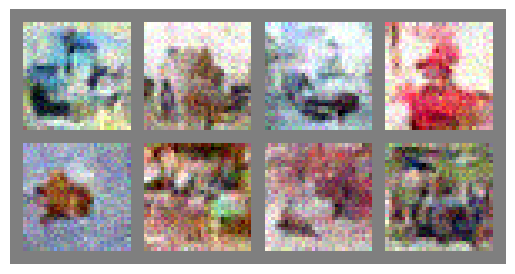

In [65]:
fig = plt.figure()
ims = []
for i in range(0, pipeline.n_timesteps, 50):
    image_grid = reverse_transform(make_grid(predicted_imgs[i], nrow=4, padding=4))
    im = plt.imshow(image_grid, animated=True)
    ims.append([im])

plt.axis('off')
animate = animation.ArtistAnimation(fig, ims, interval=10, blit=True, repeat_delay=10000)
animate.save("ddpm.gif", writer="pillow")

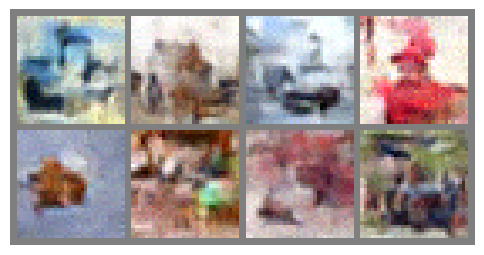

In [71]:
plt.figure(figsize=(6, 6))
plt.imshow(reverse_transform(make_grid(predicted_imgs[-1], nrow=4, padding=2)))
plt.axis("off") 
plt.show()